This notebook runs experiments on comparing the difference between time used by three forking methods

1. Copying a coroutine
2. Copying a process
3. Replaying a coroutine

by [**Kai Xu**](http://xukai92.github.io/) on **07/10/2016**

Let's start by loading some essential packages: `Gadfly` for plotting and aimed forking methods from `Turing`.

In [1]:
using Gadfly
import Turing: TraceC, TraceR, fork

    +(AbstractArray, DataArrays.DataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /Users/kai/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /Users/kai/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


Functions below are used to compute statics for plotting

In [2]:
function stds(times)
    map(v -> std([Float64(t) for t in v]), times)
end

function means(times)
    map(v -> mean(v), times)
end;

At different running time of the task, a batch of tasks are forked, and the time of forking each task is recorded. 

The function below did this batch forking process and returns the times.

In [3]:
function batch_copy(trace, num)
    times = Vector()
    for _ = 1:num
        push!(times, @elapsed fork(trace))
    end
    return times
end;

The function used for testing is a recursive version of Fibonacci sequence.

In [4]:
function fib(n)
  if n == 1 || n == 2
    res = 1
    produce(res)
    return res
  else
    res = fib(n - 1) + fib(n - 2)
    produce(res)
    return res
  end
end;

As the `fib()` is a recursive implementation, a wrapper is needed and an aimed `n`-th number from the Fibonaaci sequence is required (but not necessarily will be reached to the end, depending on the depths we recorded).

The aimed number is defined by `n_max` and the wrapper is simply named `f()`.

In [5]:
n_max = 100

function f()
  fib(n_max)
end;

Now we can run the experiments by calling `batch_copy` at differently time of the original task. The depth we record is up to 100 (defined by `depth_max`) and the number of tasks to be copied in a batch is 100 (defined by `num`).

In [32]:
depth_max = 100
num = 100

trace = TraceC(f)

coroutine_times = Array{Vector}(depth_max)
for depth = 1:depth_max
    coroutine_times[depth] = batch_copy(trace, num)
    consume(trace)
end
coroutine_times = coroutine_times .* 1000

trace = TraceR(f)

replaying_times = Array{Vector}(depth_max)
for depth = 1:depth_max
    replaying_times[depth] = batch_copy(trace, num)
    consume(trace)
end
replaying_times = replaying_times .* 1000;

Then we can make the plot now, using the predefined `means` and `stds` functions in the beginning to generate statistics.

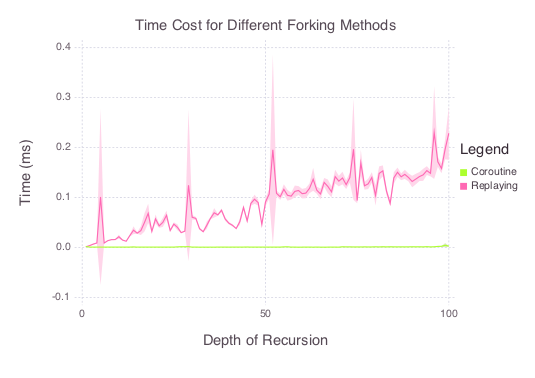

In [33]:
coroutine_means = means(coroutine_times)
coroutine_stds = stds(coroutine_times)
coroutine_mins = coroutine_means .- (1.96 * coroutine_stds / sqrt(depth_max))
coroutine_maxs = coroutine_means .+ (1.96 * coroutine_stds / sqrt(depth_max))

coroutine_layer = layer(
    x=1:depth_max, y=coroutine_means, ymin=coroutine_mins, ymax=coroutine_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"greenyellow")
)

replaying_means = means(replaying_times)
replaying_stds = stds(replaying_times)
replaying_mins = replaying_means - (1.96 * replaying_stds / sqrt(depth_max))
replaying_maxs = replaying_means + (1.96 * replaying_stds / sqrt(depth_max))

replaying_layer = layer(
    x=1:depth_max, y=replaying_means, ymin=replaying_mins, ymax=replaying_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"hotpink")
)

p = plot(
    coroutine_layer, replaying_layer,
    Guide.xlabel("Depth of Recursion"), Guide.ylabel("Time (ms)"),
    Guide.title("Time Cost for Different Forking Methods"),
    Guide.manual_color_key("Legend",["Coroutine","Replaying"], ["greenyellow", "hotpink"])
)

And save the plot.

In [ ]:
draw(PDF("exp2.pdf", 5inch, 3.75inch), p)

Alternatively, it may be more straightforward to run the same experiment on a stack versin of Fibonaaci, which is defined as below.

In [27]:
function fib_stack()
    stack = []
    push!(stack, 1)
    produce(stack[end])
    push!(stack, 1)
    produce(stack[end])
    while true
        push!(stack, stack[end - 1] + stack[end])
        produce(stack[end])
    end
end

fib_stack (generic function with 1 method)

In [28]:
depth_max = 100
num = 100

trace = TraceC(fib_stack)

coroutine_times = Array{Vector}(depth_max)
for depth = 1:depth_max
    coroutine_times[depth] = batch_copy(trace, num)
    consume(trace)
end
coroutine_times = coroutine_times .* 1000

trace = TraceR(f)

replaying_times = Array{Vector}(depth_max)
for depth = 1:depth_max
    replaying_times[depth] = batch_copy(trace, num)
    consume(trace)
end
replaying_times = replaying_times .* 1000;

And same, the plot.

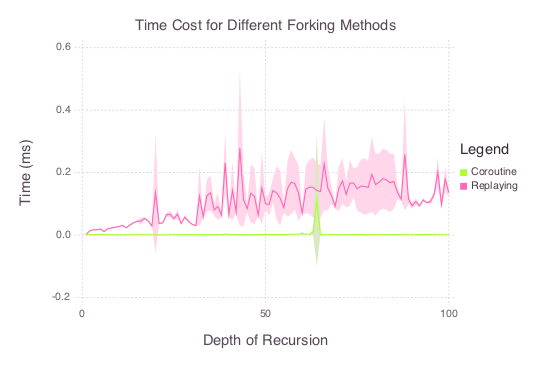

In [31]:
coroutine_means = means(coroutine_times)
coroutine_stds = stds(coroutine_times)
coroutine_mins = coroutine_means .- (1.96 * coroutine_stds / sqrt(depth_max))
coroutine_maxs = coroutine_means .+ (1.96 * coroutine_stds / sqrt(depth_max))

coroutine_layer = layer(
    x=1:depth_max, y=coroutine_means, ymin=coroutine_mins, ymax=coroutine_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"greenyellow")
)

replaying_means = means(replaying_times)
replaying_stds = stds(replaying_times)
replaying_mins = replaying_means - (1.96 * replaying_stds / sqrt(depth_max))
replaying_maxs = replaying_means + (1.96 * replaying_stds / sqrt(depth_max))

replaying_layer = layer(
    x=1:depth_max, y=replaying_means, ymin=replaying_mins, ymax=replaying_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"hotpink")
)

p = plot(
    coroutine_layer, replaying_layer,
    Guide.xlabel("Depth of Recursion"), Guide.ylabel("Time (ms)"),
    Guide.title("Time Cost for Different Forking Methods"),
    Guide.manual_color_key("Legend",["Coroutine","Replaying"], ["greenyellow", "hotpink"])
)

And again save the plot.

In [ ]:
draw(PDF("exp2stack.pdf", 5inch, 3.75inch), p)